# Task 3: All2All Training

In [14]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Model Definition

In [15]:
from FNO_bn import FNO1d_bn

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Import Data

In [17]:
torch.manual_seed(0)
np.random.seed(0)

In [18]:
class PDEDataset(Dataset):
    def __init__(self,
                 which="training",
                 training_samples = 256,
                 resolution = 128,
                 device='cpu'):

        self.resolution = resolution
        self.device = device
        self.data = np.load(f"data/data_train_{resolution}.npy")

        self.T = 5
        # Precompute all possible (t_initial, t_final) pairs within the specified range.
        self.time_pairs = [(i, j) for i in range(0, self.T) for j in range(i + 1, self.T)]
        self.len_times  = len(self.time_pairs)

        # Total samples available in the dataset
        total_samples = self.data.shape[0]
        self.n_val = 32
        self.n_test = 32

        if which == "training":
            self.length = training_samples * self.len_times
            self.start_sample = 0
        elif which == "validation":
            self.length = self.n_val * self.len_times
            self.start_sample = total_samples - self.n_val - self.n_test
        elif which == "test":
            self.length = self.n_test * self.len_times
            self.start_sample = total_samples - self.n_test

        self.mean = 0.018484
        self.std  = 0.685405
        
        # Pre-create grid to avoid recreating it each time
        self.grid = torch.linspace(0, 1, 128, dtype=torch.float32).reshape(128, 1).to(device)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        sample_idx = self.start_sample + index // self.len_times
        time_pair_idx = index % self.len_times
        t_inp, t_out = self.time_pairs[time_pair_idx]
        time = torch.tensor((t_out - t_inp)/4. + float(np.random.rand(1)[0]/10**6), dtype=torch.float32, device=self.device)

        inputs = torch.from_numpy(self.data[sample_idx, t_inp]).type(torch.float32).reshape(128, 1).to(self.device)
        inputs = (inputs - self.mean)/self.std #Normalize
        
        # Add grid coordinates (already on correct device and dtype)
        inputs = torch.cat((inputs, self.grid), dim=-1)  # (128, 2)

        outputs = torch.from_numpy(self.data[sample_idx, t_out]).type(torch.float32).reshape(128).to(self.device)
        outputs = (outputs - self.mean)/self.std #Normalize

        return time, inputs, outputs

In [19]:
# Check actual data statistics
train_data = np.load("data/data_train_128.npy")
print(f"Training data shape: {train_data.shape}")
print(f"Training data mean: {train_data.mean():.6f}")
print(f"Training data std: {train_data.std():.6f}")
print(f"Training data min: {train_data.min():.6f}")
print(f"Training data max: {train_data.max():.6f}")

Training data shape: (1024, 5, 128)
Training data mean: 0.018484
Training data std: 0.685405
Training data min: -3.095698
Training data max: 3.086819


### Instantiate Model

In [20]:
n_train = 1024 # Number of TRAJECTORIES for training
batch_size = 128

training_set = DataLoader(PDEDataset("training", n_train, device=device), batch_size=batch_size, shuffle=True)
testing_set = DataLoader(PDEDataset("validation", device=device), batch_size=batch_size, shuffle=False)

learning_rate = 0.001
epochs = 100
step_size = 10
gamma = 0.5

modes = 16
width = 64 # 64
fno = FNO1d_bn(modes, width).to(device)  # model

optimizer = torch.optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',           # Minimize validation loss
    factor=0.5,          # Multiply LR by 0.5
    patience=5,          # Wait 5 epochs before reducing
    min_lr=1e-6         # Don't go below this
)

### Train Loop

In [21]:
# Define the error function
def relative_l2_error(pred, true):
    diff_norm = torch.norm(pred - true, p=2, dim=1)
    true_norm = torch.norm(true, p=2, dim=1)
    return torch.mean(diff_norm / true_norm) * 100

l = nn.MSELoss()  
freq_print = 1

for epoch in range(epochs):
    fno.train()
    train_mse = 0.0
    for step, (time_batch, input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch, time_batch).squeeze(-1)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)


    # Validation with CORRECT L2 error
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (time_batch, input_batch, output_batch) in enumerate(testing_set):
            output_pred_batch = fno(input_batch, time_batch).squeeze(-1)
            # Use the correct relative L2 error
            loss_f = relative_l2_error(output_pred_batch, output_batch)
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(testing_set)
    scheduler.step(test_relative_l2)


    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)

######### Epoch: 0  ######### Train Loss: 0.08505532889394089  ######### Relative L2 Test Norm: 10.145382245381674
######### Epoch: 1  ######### Train Loss: 0.012417467695195228  ######### Relative L2 Test Norm: 7.332700888315837
######### Epoch: 2  ######### Train Loss: 0.009528728431905619  ######### Relative L2 Test Norm: 6.2233812014261884
######### Epoch: 3  ######### Train Loss: 0.008457307692151517  ######### Relative L2 Test Norm: 8.631126880645752
######### Epoch: 4  ######### Train Loss: 0.007147405482828617  ######### Relative L2 Test Norm: 9.049049059549967
######### Epoch: 5  ######### Train Loss: 0.008953504521923606  ######### Relative L2 Test Norm: 6.018386999766032
######### Epoch: 6  ######### Train Loss: 0.007995878606743645  ######### Relative L2 Test Norm: 8.503318627675375
######### Epoch: 7  ######### Train Loss: 0.005439686711179092  ######### Relative L2 Test Norm: 8.043031692504883
######### Epoch: 8  ######### Train Loss: 0.0053146956648561176  ######### Rela

In [22]:
# save trained model
# torch.save(fno.state_dict(), "fno1d_bn_model.pth")


### Test model for predictions at $t = 1$

In [23]:
# Load test data at resolution 128
test_data_raw = np.load("data/data_test_128.npy")
spatial_resolution = 128

# Extract initial conditions (t=0) and final time solutions (t=1)
initial_conditions = test_data_raw[:, 0, :]  # Shape: (n_samples, 128)
final_time_ground_truth = test_data_raw[:, -1, :]  # Shape: (n_samples, 128)

# Prepare initial conditions with grid coordinates
grid = torch.linspace(0, 1, spatial_resolution, dtype=torch.float32).reshape(spatial_resolution, 1)
initial_conditions_tensor = torch.from_numpy(initial_conditions).type(torch.float32).reshape(-1, spatial_resolution, 1)

# Add grid coordinates to each sample
initial_conditions_with_grid = torch.cat([initial_conditions_tensor, grid.repeat(initial_conditions_tensor.shape[0], 1, 1)], dim=-1)

# Normalize initial conditions
mean = 0.018484
std = 0.685405
initial_conditions_with_grid[:, :, 0] = (initial_conditions_with_grid[:, :, 0] - mean) / std

# Prepare time tensor (full time span from 0 to 1)
time_full = torch.ones(initial_conditions_with_grid.shape[0], dtype=torch.float32) * 1.0

# Move to device
initial_conditions_with_grid = initial_conditions_with_grid.to(device)
time_full = time_full.to(device)

print(f"Test samples: {initial_conditions_with_grid.shape[0]}")
print(f"Input shape: {initial_conditions_with_grid.shape}")
print(f"Time values: {time_full[0].item()}")

Test samples: 128
Input shape: torch.Size([128, 128, 2])
Time values: 1.0


In [24]:
# Test the model: predict from t=0 to t=1
batch_size_test = 20
n_test_samples = initial_conditions_with_grid.shape[0]

all_predictions = []
fno.eval()
with torch.no_grad():
    for i in range(0, n_test_samples, batch_size_test):
        batch_end = min(i + batch_size_test, n_test_samples)
        batch_input = initial_conditions_with_grid[i:batch_end]
        batch_time = time_full[i:batch_end]
        
        # Predict final time
        predictions = fno(batch_input, batch_time).squeeze(-1)
        all_predictions.append(predictions)

# Concatenate all predictions
all_predictions = torch.cat(all_predictions, dim=0)

# Denormalize predictions
all_predictions_denorm = all_predictions * std + mean

# Convert ground truth to tensor
final_time_ground_truth_tensor = torch.from_numpy(final_time_ground_truth).type(torch.float32).to(device)

# Calculate relative L2 error
relative_l2_error = torch.mean(torch.norm(all_predictions_denorm - final_time_ground_truth_tensor, dim=1) / 
                                torch.norm(final_time_ground_truth_tensor, dim=1)) * 100

print(f"Relative L2 Error: {relative_l2_error:.4f}%")


Relative L2 Error: 1.9651%


### Test model for predictions at multiple time steps

In [25]:
# use the model to make predictions at multiple time steps: t = 0.25, t =0.50, t = 0.75, t = 1.0. Compute the average relative L2 error for each time step
time_steps = [0.25, 0.50, 0.75, 1.0]
relative_l2_errors = []
for t in time_steps:
    time_tensor = torch.ones(initial_conditions_with_grid.shape[0], dtype=torch.float32) * t
    time_tensor = time_tensor.to(device)

    all_predictions_t = []
    fno.eval()
    with torch.no_grad():
        for i in range(0, n_test_samples, batch_size_test):
            batch_end = min(i + batch_size_test, n_test_samples)
            batch_input = initial_conditions_with_grid[i:batch_end]
            batch_time = time_tensor[i:batch_end]
            
            # Predict at time t
            predictions_t = fno(batch_input, batch_time).squeeze(-1)
            all_predictions_t.append(predictions_t)

    # Concatenate all predictions
    all_predictions_t = torch.cat(all_predictions_t, dim=0)

    # Denormalize predictions
    all_predictions_t_denorm = all_predictions_t * std + mean

    # Get ground truth at time t
    t_index = int(t * 4)  # Since we have 5 time steps (0, 0.25, 0.5, 0.75, 1.0)
    ground_truth_t = test_data_raw[:, t_index, :]
    ground_truth_t_tensor = torch.from_numpy(ground_truth_t).type(torch.float32).to(device)

    # Calculate relative L2 error
    rel_l2_error_t = torch.mean(torch.norm(all_predictions_t_denorm - ground_truth_t_tensor, dim=1) / 
                                torch.norm(ground_truth_t_tensor, dim=1)) * 100

    relative_l2_errors.append(rel_l2_error_t.item())
    print(f"Relative L2 Error at t={t}: {rel_l2_error_t:.4f}%")

Relative L2 Error at t=0.25: 1.6458%
Relative L2 Error at t=0.5: 1.5554%
Relative L2 Error at t=0.75: 1.6436%
Relative L2 Error at t=1.0: 1.9651%


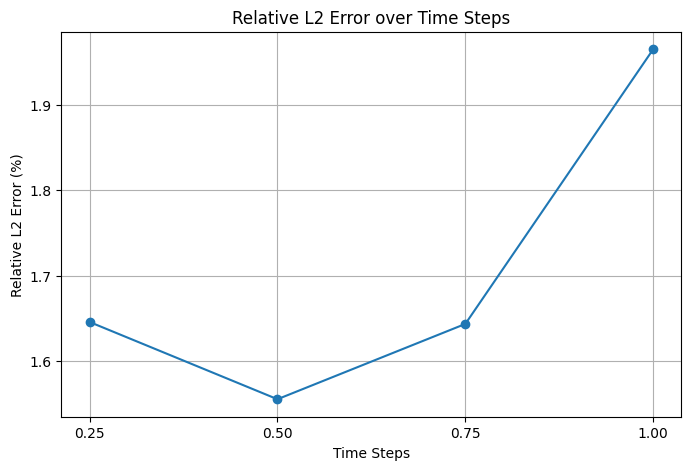

In [26]:
# plot relative L2 errors over time steps
plt.figure(figsize=(8, 5))
plt.plot(time_steps, relative_l2_errors, marker='o')
plt.title('Relative L2 Error over Time Steps')
plt.xlabel('Time Steps')
plt.xticks(time_steps)
plt.ylabel('Relative L2 Error (%)')
plt.grid(True)
plt.show()